In [1]:
!pip install gymnasium[mujoco]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 61.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt

# ჰიპერპარამეტრები
ძალიან, ძალიან დიდი ხანი ვტუნავდი ჰიპერპარამეტრებს რომ კარგი მოდელი გამოსულიყო ; (

ალბათ 200ჯერ გავუშვებდი ამ ნოუთბუქს ამ ტიუნინგის პროცესში...

* **STEPS**: მაქსიმალური რაოდენობის სვლა თითო ეპიზოდში
* **EPISODES**: მაქსიმალური რაოდენობა ეპიზოდების მთლიანად დასატრენინგებლად
* **DISCOUNT_FACTOR**: დისქაუნთი, ანუ რამდენად აფასებს მომავლის რევარდს მოდელი
* **GAE_LAMBDA**: GAE ალგორითმის სპეციფიკური ჰიპერპარამეტრი
* **CLIPPING**: PPO ალგორითმის სპეციფიკური ჰიპერპარამეტრი
* **LEARNING_RATE**: საწყისი შესწავლის სიჩქარე
* **UPDATE_FREQUENCY**: რამდენჯერ დააფდეითდეს policy თითო ტრენინგის სესიაში.
* **LEAKY_RELU**: LeakyReLu-ს პარამეტრი,https://pytorch.org/docs/stable/_images/LeakyReLU.png
* **EARLY_STOP_THRESHOLD**: რა რევარდზე შეგვიძლია ჩავთვალოთ რომ საკმარისია მოდელის პერფორმანსი
* **EARLY_STOP_PATIENCE**: რამდენჯერ მოვიცადოთ ზედა ჰიპერპარამეტრზე გადაცილება
* **PROBLEM**: რომელ მუჯოკოს პრობლემაზე ვაკეთებთ მოდელს.

In [3]:
STEPS = 1000
EPISODES = 30000
DISCOUNT_FACTOR = 0.95
GAE_LAMBDA = 0.95
CLIPPING = 0.10
LEARNING_RATE = 0.001
UPDATE_FREQUENCY = 2
LEAKY_RELU = 0.05
LOG = 100
EARLY_STOP_THRESHOLD = 1000.0
EARLY_STOP_PATIENCE = 5
PROBLEM = 'InvertedDoublePendulum-v4'

print(torch.cuda.is_available())
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

True
12.1
Using device: cuda


# მოდელის ტრენინგის ალგორითმების არჩევა

მოდელის, სწავლის ალგორითმების და ჰიპერპარამეტრების შერჩევისას/გატესტვისას შევამჩნიე რომ ძალიან მნიშვნელოვანი იყო სტაბილურობა. ხშირად იყო შემთხვევა რომ ძალიან პატარა ცვლილებამ გამოიწვია არასტაბილურობა და რაღაც პერიოდის მერე (ტრენინგისას) გაჭედილი იყო რაღაც ნაწილას და ვეღარ აუმჯობესებდა რევარდს. ამიტომ გადავწყვიტე რომ ისეთი გადაწყვეტილებები მიმეღო რომელიც სტაბილურობას გაუმჯობესებდა და ცუდი Policy ცვლილებისას შეძლებდა უკან დახევას და სხვა გადაწყვეტილებისკენ წასვლას.

# PPO
სწავლის ალგორითმის არჩევისას, პროქსიმალური პოლიტიკის ოპტიმიზაცია (PPO) კარგი არჩევანია. PPO ეხმარება ტრენინგი უფრო სტაბილური გახდეს სხვა მეთოდებთან შედარებით, რითიც თავიდან იცილებს დიდ განახლებებს, რამაც შეიძლება გამოიწვიოს პრობლემები. ამ ხრიკს ეწოდება Clipping. ამ ფეიფერში არის გარჩეული ეს ტაქტიკა: https://arxiv.org/pdf/1707.06347.

TRPO-სთან შედარებით ბევრად უფრო მარტივი დასაიმპლემენტირებელია ეს ალგორითმი და შედარებით უფრო სწრაფიც.

ჯერჯერობით გადავწყვიტე რომ ამ ალგორითმით გავაგრძელო.


# GAE
განზოგადებული უპირატესობის შეფასება (GAE) არის ტექნიკა, რომელიც გამოიყენება გაძლიერებული სწავლის სტაბილურობისა და ეფექტურობის გასაუმჯობესებლად. ეს ხელს უწყობს სავარაუდო უპირატესობების ვარიაციის შემცირებას, ხოლო bias-ის დაბალ შენარჩუნებას. ეს კეთდება უპირატესობის ფუნქციის სხვადასხვა შეფასების კომბინაციით, უფრო საიმედო შეფასების მისაღებად.

უფრო მარტივად რომ ავხსნა, GAE აბალანსებს ორ რამეს, მოკლე ვადიან მოგებას და შორ ვადიან მოგებას ერთმანეთთან. ამით არც ისეთ გადაწყვეტილებებს მიიღებს რაც შეიძლება ზედმეტად Greedy და მოკლევადიანი გამოვიდეს და არც ზედმეტად შორს იყურება რომ დააიგნოროს ახლო მომავალი. ამისთვისაც ეს სტატია ვნახე თავიდან გამოკვლევისას: https://arxiv.org/pdf/1506.02438

# მოდელის არქიტექტურა - აქტორ-კრიტიკი

აქტორ-კიტიკი არქიტექტურა საკმაოდ პოპულარული არჩევანია მანქანურ სწავლებაში რადგანაც მას შეუძლია ერთდროულად ისწავლოს გადაწყვეტილებების მიღება და შეფასება. აქტორის ქსელი იღებს გადაწყვეტილებებს, ხოლო კრიტიკის ქსელი ამ მიღებულ გადაწყვეტილებებს აფასებს.

ასევე, ესეთი არქიტექტურის მოდელები სტაბილურები არიან რადგანაც ნაკლები ვარიაცია აქვთ და goto არქიტექტურა არის ასეთი აგენტების სწავლებისთვის

იმპლემენტაცია ასეთი მაქვს:

1. აქტორის ნეირონული ქსელი: აბრუნებს გადაწყვეტილებების დისტრიბუციიდან საშუალო მნიშვნელობას.
2. კრიტიკს ნეირონული ქსელი: აბრუნებს ახლა რა state-შიც იმყოფება მაგის სავარაუდო შეფასებას.

ეს ორივე კომპონენტი feedforward neural network-ივით იქნება გადაბმული

In [4]:
class ActorCriticPolicy(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(ActorCriticPolicy, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.LeakyReLU(LEAKY_RELU),
            nn.Linear(100, 100),
            nn.LeakyReLU(LEAKY_RELU),
            nn.Linear(100, action_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.LeakyReLU(LEAKY_RELU),
            nn.Linear(100, 100),
            nn.LeakyReLU(LEAKY_RELU),
            nn.Linear(100, 1)
        )
        self.init_weights(self.actor)
        self.init_weights(self.critic)
        
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    
    def init_weights(self, network):
        for layer in network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        action_mean = self.actor(x)
        action_std = self.log_std.exp().expand_as(action_mean)
        value = self.critic(x)
        return action_mean, action_std, value

### არ გაამართლა ამ მოდელმა
class RNNPolicy(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim=128):
        super(RNNPolicy, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, action_dim)
        
        self.log_std = nn.Parameter(torch.zeros(action_dim))

        self.critic = nn.Linear(hidden_dim, 1)

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_dim).to(device),
                torch.zeros(1, batch_size, self.hidden_dim).to(device))

    def forward(self, x, hidden_state):
        lstm_out, hidden_state = self.lstm(x, hidden_state)
        last_out = lstm_out[:, -1, :]
        action_mean = self.fc(last_out)
        value = self.critic(last_out)
        return action_mean, self.log_std, value, hidden_state



# მოდელის არქიტექტურის აღწერა

თითო ქსელისთვის ვიყენებ ორ hidden layerს. 100 ნეირონით თითო ლეიერს. სრულიად წრფივი რომ არ იყოს ვიყენებ ReLu-ს ალტერნატივას, LeakyReLu-ს.

ბევრი სხვადასხვა რაოდენობა და არქიტექტურები გამოვიყენე აქ საკმაოდ. RNN-იც ვცადე და არ გაამართლა, შეიძლება უბრალოდ კარგად ვერ ავაწყე. რაც შეეხება უშუალოდ 100 ნეირონი რატომ ავირჩიე, ბევრი ტიუნინგის შემდეგ ამ რიცხვებზე გავჩერდი. შევამჩნიე რომ რაც უფრო დიდი capacity ანუ ნეირონები აქვს ქსელს, მით უფრო რთულად და ნელა მიდის მისი სწავლება, ბევრად უფრო მეტი დრო სჭირდება რომ ისწავლოს, ლოგიკურიც არის. ზედმეტად პატარას რომ ვიღებდი უბრალოდ რაღაც რევარდს აღარ სცდებოდა. ამიტომ რაღაც ბალანსი უნდა მეპოვა.



# GAE-ს კოდი

აქ ასევე სხვა ალგორითმებიც გავტესტე, მაგრამ გამოცდილებიდან GAE ყველაზე მეტად გამოდგა.

In [5]:
def gae(next_value, rewards, masks, values, gamma=DISCOUNT_FACTOR, tau=GAE_LAMBDA):
    values = values + [next_value]
    _gae = 0
    advantages = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * masks[i] - values[i]
        _gae = delta + gamma * tau * masks[i] * _gae
        advantages.insert(0, _gae + values[i])
    return advantages

def td_lambda(next_value, rewards, masks, values, gamma=DISCOUNT_FACTOR, lambda_=GAE_LAMBDA):
    td_targets = []
    last_td_target = next_value
    
    for i in reversed(range(len(rewards))):
        td_target = rewards[i] + gamma * last_td_target * masks[i]
        td_targets.insert(0, td_target)
        last_td_target = td_target
        
    return td_targets

def n_step_returns(next_value, rewards, masks, values, gamma=DISCOUNT_FACTOR, n=5):
    advantages = []
    for t in range(len(rewards)):
        R = next_value
        for k in range(n):
            if t + k < len(rewards):
                R += (gamma ** k) * rewards[t + k]
            else:
                break
        advantages.append(R)
    return advantages

# PPO-ს კოდი

In [6]:
def ppo(agent, optimizer, previous_log_probs, batch_states, batch_actions, target_returns, advantage_estimates, clipping=CLIPPING, epochs=UPDATE_FREQUENCY):
    for _ in range(epochs):
        means, stds, value_estimates = agent(batch_states)
        distribution = torch.distributions.Normal(means, stds)
        current_log_probs = distribution.log_prob(batch_actions).sum(dim=-1)
        policy_entropy = distribution.entropy().sum(dim=-1).mean()

        prob_ratio = (current_log_probs - previous_log_probs).exp()

        surrogate1 = prob_ratio * advantage_estimates
        surrogate2 = torch.clamp(prob_ratio, 1.0 - clipping, 1.0 + clipping) * advantage_estimates
        policy_loss = -torch.min(surrogate1, surrogate2).mean()

        value_loss = (target_returns - value_estimates).pow(2).mean()

        total_loss = 0.5 * value_loss + policy_loss - 0.01 * policy_entropy

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

# თითო ეპიზოდის გაშვება

თითო იტერაციაზე ვითვლით აგენტისგან დაბრუნებულ საშუალოს და სტანდარტულ გადახრას. ამით ვაგებთ ნორმალურ დისტრიბუციას, რანდომულად ვიღებთ sample-ს, ლოგარითმულ ალბათობას ვითვლით და შემდეგ ვკლიპავთ (ppo-ს მიხედვით). ამით უკვე გამოვთვალეთ გადაწყვეტილება და ამ გადაწყვეტილებას უკვე ვიღებთ გარემოში. ამ ყველაფერს ვინახავთ. და ეპიზოდის ბოლოს ვაბრუნებთ ყოველ იტერაციაზე ამ დათვლილ ცვლადებს

In [7]:
def run_env(agent, environment):
    initial_state, _ = environment.reset()
    trajectory = {
        "states": [],
        "actions": [],
        "rewards": [],
        "dones": [],
        "values": [],
        "log_probs": []
    }

    current_state = initial_state
    for iteration in range(STEPS):
        current_tensor = torch.tensor(current_state, dtype=torch.float32).unsqueeze(0).to(device)
        mean_action, std_action, state_value = agent(current_tensor)
        probability_distribution = torch.distributions.Normal(mean_action, std_action)
        sampled_action = probability_distribution.sample()
        log_probability = probability_distribution.log_prob(sampled_action).sum(dim=-1)
        clipped_action = sampled_action[0].clamp(-2, 2).cpu().numpy()
        next_state, reward, done, _, _ = environment.step(clipped_action)

        trajectory["current_state"] = next_state
        trajectory["states"].append(current_tensor)
        trajectory["actions"].append(sampled_action)
        trajectory["rewards"].append(reward)
        trajectory["dones"].append(1 - done)
        trajectory["values"].append(state_value)
        trajectory["log_probs"].append(log_probability)
        
        if done:
            break
        
        current_state = next_state

    return trajectory


# ტრენინგის ციკლი

მაქსიმუმ ეპიზოდების რაოდენობით გადავუყვებით და ვატრენინგებთ მოდელს. ყოველ ჯერზე ვუშვებთ ეპიზოდს, ვითვლით gae-ს და ახალ ტენზორებს. შემდეგ ვუშვებთ ppo-ს ამ გამოთვლითი ტენზორებით და ვლოგავთ საშუალო რევარდს ჰიპერპარამეტრის მიხედვით. საბოლოოდ ვბეჭდავთ რევარდის გრაფიკს, ტრენინგისას როგორ ადიოდა-ჩადიოდა.

ასევე, დამატებით, ვიყენებ Early Stopping-ს რომ ტყუილა არ გაგრძელდეს ტრენინგი როცა უკვე ვიცით რომ მოდელი საკმარისად კარგია.

In [8]:
def train(agent, environment):
    optimizer = torch.optim.Adam(agent.parameters(), lr=LEARNING_RATE)
    reward_averages = []
    cumulative_reward = 0
    patience_counter = 0
    
    for episode_num in range(EPISODES):
        trajectory = run_env(agent, environment)

        last_state_tensor = torch.tensor(trajectory["current_state"], dtype=torch.float32).unsqueeze(0).to(device)
        _, _, last_value = agent(last_state_tensor)
        
        ### რამდენიმე სხვა და სხვა ვარიანტი ვცადე gae-ს მაგივრად, მაგრამ gae ყველაზე კარგი აღმოჩნდა
        returns = gae(last_value, trajectory["rewards"], trajectory["dones"], trajectory["values"])
        # returns = td_lambda(last_value, reward_list, mask_list, value_list)
        # returns = n_step_returns(last_value, reward_list, mask_list, value_list)

        tensors = {
            "returns": torch.cat(returns).detach().to(device),
            "log_probs": torch.cat(trajectory["log_probs"]).detach().to(device),
            "values": torch.cat(trajectory["values"]).detach().to(device),
            "states": torch.cat(trajectory["states"]).to(device),
            "actions": torch.cat(trajectory["actions"]).to(device),
        }
        tensors["advantages"] = tensors["returns"] - tensors["values"]
        cumulative_reward += sum(trajectory["rewards"])

        ppo(agent, optimizer, tensors["log_probs"], tensors["states"], tensors["actions"], tensors["returns"], tensors["advantages"])

        if episode_num % LOG != 0:
            continue
            
        avg_reward = cumulative_reward / LOG
        reward_averages.append(avg_reward)
        print(f"{episode_num}: {avg_reward}")
        cumulative_reward = 0
        
        if avg_reward >= EARLY_STOP_THRESHOLD:
            patience_counter += 1
            if patience_counter >= EARLY_STOP_PATIENCE:
                print(f"ნაადრევად გაჩერება: {episode_num}\nბოლო ეპიზოდის რევარდი: {avg_reward}")
                break

    results(reward_averages)

# მოდელის ტრენინგის მონიტორინგი

მარტივად ვხატავ საშუალო რევარდი რა იყო ყოველ 100 ეპიზოდში ერთხელ. ამით უკეთესად ვაკეთებდი ვიზუალიზაციას ჩემი მოდელი როგორ სწრაფად ან სტაბილურად სწავლობა, ან სადმე თუ იჭედებოდა ტრენინგის დროს.

In [9]:
def results(average_rewards):
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot([LOG * i for i in range(len(average_rewards))], average_rewards, label='საშუალო რევარდი', color='orange')
    plt.title('საშუალო რევარდი')
    plt.xlabel('ეპიზოდი')
    plt.ylabel('საშუალო რევარდი')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# დატრენინგება

0: 0.4543197500768848
100: 38.009154807063766
200: 67.44045514641573
300: 89.46584701987025
400: 91.79196715400445
500: 89.72800415318669
600: 90.10935788431216
700: 92.88539452631275
800: 87.52151914166994
900: 88.56356859880225
1000: 92.86360296257654
1100: 89.21633114933945
1200: 83.98024258682673
1300: 117.59024404009443
1400: 121.90687378980016
1500: 114.10370290108649
1600: 145.13900203530207
1700: 155.10288311539747
1800: 158.00995281124793
1900: 143.11410225594625
2000: 151.05854943584052
2100: 163.50477354929708
2200: 179.31791802001396
2300: 149.50919371493208
2400: 206.17977957008807
2500: 201.6763439960766
2600: 200.5766774397272
2700: 205.8588626807407
2800: 201.05900253626507
2900: 159.84729677054008
3000: 179.35576476147529
3100: 192.38814718730941
3200: 192.0517929338173
3300: 220.40236961162762
3400: 197.49054830053726
3500: 214.65921043767284
3600: 161.5703689353161
3700: 96.00530134070269
3800: 147.12282253729984
3900: 210.30136224887872
4000: 155.28731656435068
4100

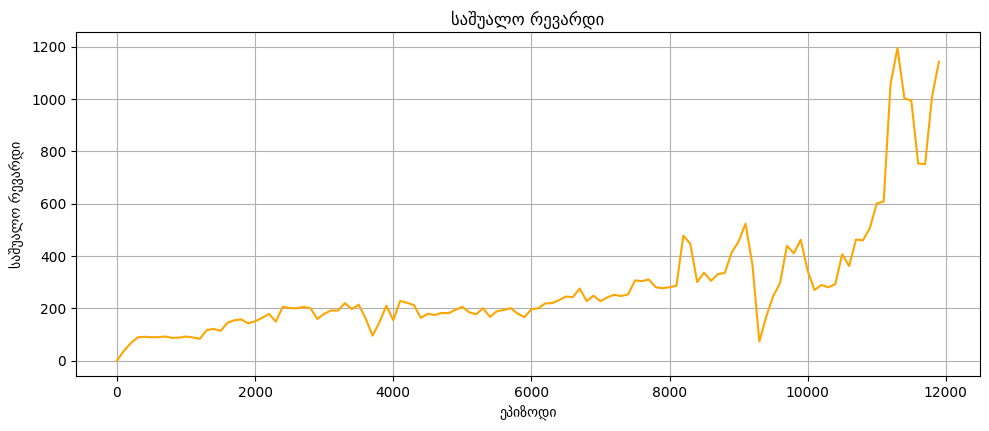

In [10]:
env = gym.make(PROBLEM)
input_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# policy = torch.load('model.w').to(device)

policy = ActorCriticPolicy(input_dim, action_dim).to(device)
train(policy, env)
torch.save(policy, 'model.w')

# მოდელის ვიზუალიზაცია

საბოლოოდ მაქვს ეს ფუნქცია რომელიც ამოაგდებს მუჯოკოს ვიზუალიზაციას და გვანახებს რამდენად კარგია მოდელი. kaggle-ზე ვერ ავამუშავე თვითონ ვიზუალიზაციის პროგრამა opengl-ის გამო (თუ რაღაც მსგავსი ერორის), ამიტომ ეს ნოუთბუქი ინახავს 'model.w' ფაილს  რომლის შემდეგ ჩატვირთვა შეიძლება torch.load()-ით. ზედა cell-ში არის დაკომენტარებული. მე პირადად კაგლიდან ვიწერდი ამ მოდელს და ლოკალურად ვუშვებდი შემდეგ კაგლზე დატრენინგებულ მოდელს რომ ვიზუალიზაცია გამეკეთებინა.

In [11]:
policy.eval()
counter = 0
environment = gym.make(PROBLEM, render_mode='human')
observation, _ = environment.reset()

while True:
    counter += 1
    
    observation_tensor = torch.tensor(observation, dtype=torch.float32).unsqueeze(0).to(device)
    mean_action, std_action, _ = policy(observation_tensor)
    distribution = torch.distributions.Normal(mean_action, std_action)
    selected_action = distribution.sample()
    clipped_action = selected_action[0].clamp(-2, 2).cpu().numpy()
    
    observation, _, terminated, _, _ = environment.step(clipped_action)

    if terminated or counter > STEPS:
        counter = 0
        observation, _ = environment.reset()


# შეჯამება

საბოლოო ჯამში, ძალიან ბევრი ვეწვალე ამ დავალებას : D, არ მეგონა რომ ასეთი რთული იქნებოდა. 

წესით და რიგით, გამომივიდა ისეთი მოდელი რომელიც არც ისე ცუდად მუშაობს, performance ნორმალური აქვს, ტრენინგს ცოტა დიდხანს უნდება მაგრამ მე რასაც ვუყურე, კონსისტენტურად შეუძლია 1000-ზე მეტი რევარდის შოვნა თუ დრო აქვს საკმარისი. ხშირად მომივიდა რომ ისეთი პარამეტრებით დავატრენინგე რომლითაც სადღაც ლოკალურად იჭედებოდა და ვეღარ გამოდიოდა 0-100 რევარდის რეინჯიდან, ამიტომ ამ ვერსიას ვთვლი წარმატებულ მოდელის ვერსიად.

ის შევამჩნიე რომ ძააალიან პატარა ჰიპერპარამეტრების ცვლილებით ძალიან იცვლებოდა პერფორმანსი და ტრენინგი მოდელის, მივხვდი რომ უმეტესწილად შეიძლება მოდელის არქიტექტურა არც იყოს პრობლემა და უბრალოდ ბევრი trial and error უნდა განვიცადო ჰიპერპარამეტრების ტიუნინგისას.